In [ ]:
# Flexynesis

In [1]:
## data import
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


In [ ]:
# Functions

In [29]:
# Functions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os


def prepare_and_save_data(test_size=0.3, random_seed=42, debug=True):

    load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"
    metadata_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx"
    save_base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    # 读取数据
    HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
    LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"), index_col=0)
    PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"), index_col=0)
    BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"), index_col=0)
    metadata = pd.read_excel(metadata_path)

    metadata['SampleId'] = metadata['SampleId'].astype(int)
    HDF.index = HDF.index.astype(int)

    merged_df = HDF.merge(
        metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
        left_index=True,
        right_on='SampleId'
    )
    merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
    merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
    y_dm = merged_df['DIAB_num']
    y_dm.index = HDF.index

    # ========== 调试模式：缩小样本数和特征数 ==========
    if debug:
        n_sample_debug = 80
        n_feature_debug = 100
        print(f"🧪 Debug mode active: Using {n_sample_debug} samples and {n_feature_debug} features per omic")

        # 使用train_test_split实现分层采样，抽取n_sample_debug个样本
        sample_ids, _ = train_test_split(
            y_dm.index,
            train_size=n_sample_debug,
            stratify=y_dm,
            random_state=random_seed
        )
        # 用抽样后的id过滤数据
        HDF = HDF.loc[sample_ids]
        LD = LD.loc[sample_ids]
        PM = PM.loc[sample_ids]
        BM = BM.loc[sample_ids]
        y_dm = y_dm.loc[sample_ids]
        metadata = metadata[metadata['SampleId'].isin(sample_ids)]

        print("调试模式下抽样后类别分布：")

        # 截取特征前 N 个
        HDF = HDF.iloc[:, :n_feature_debug]
        LD = LD.iloc[:, :n_feature_debug]
        PM = PM.iloc[:, :n_feature_debug]
        BM = BM.iloc[:, :n_feature_debug]

    # print(y_dm.head(20))
    print(y_dm.value_counts())
    # print(HDF)

    # ========== 划分数据 ==========
    HDF_train, HDF_test, y_train, y_test = train_test_split(
        HDF, y_dm, test_size=test_size, random_state=random_seed
    )
    LD_train = LD.loc[HDF_train.index]
    LD_test  = LD.loc[HDF_test.index]
    PM_train = PM.loc[HDF_train.index]
    PM_test  = PM.loc[HDF_test.index]
    BM_train = BM.loc[HDF_train.index]
    BM_test  = BM.loc[HDF_test.index]
    Y_train = y_dm.loc[HDF_train.index]
    Y_test  = y_dm.loc[HDF_test.index]

    # 保存路径准备
    train_path = os.path.join(save_base_path, "train")
    test_path = os.path.join(save_base_path, "test")
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # 保存函数
    def save_train(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_test(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)
    
    def save_clinical_train(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_clinical_test(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

    

    # 保存训练集
    save_train(LD_train, "LD", "LD")
    save_train(PM_train, "PM", "PM")
    save_train(BM_train, "BM", "BM")
    save_train(HDF_train, "HDF", "HDF")
    save_clinical_train(Y_train, "clin")

    # 保存测试集
    save_test(LD_test, "LD", "LD")
    save_test(PM_test, "PM", "PM")
    save_test(BM_test, "BM", "BM")
    save_test(HDF_test, "HDF", "HDF")
    save_clinical_test(Y_test, "clin")

    print(f"[✓] Split ratio: {1 - test_size:.2f} train / {test_size:.2f} test | seed={random_seed}")

prepare_and_save_data(test_size=0.3,random_seed=48)

🧪 Debug mode active: Using 80 samples and 100 features per omic
调试模式下抽样后类别分布：
DIAB_num
1    43
0    37
Name: count, dtype: int64
[✓] Split ratio: 0.70 train / 0.30 test | seed=48


In [31]:
#保存文件
import os
import pandas as pd
import numpy as np
from flexynesis import HyperparameterTuning, DirectPred, DataImporter, evaluate_wrapper

def run_stability_test_metrics_only(data_types=['BM', 'HDF']):
    # 固定的参数配置
    test_sizes = [0.3]
    seeds = [0, 1, 48, 42, 2023]
    base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis predition data_best"

    all_metrics = []

    for test_size in test_sizes:
        for seed in seeds:
            print(f"\n🔁 Running for test_size={test_size}, seed={seed}")

            # 预处理数据
            prepare_and_save_data(test_size=test_size, random_seed=seed, debug=False)

            # 导入数据
            data_importer = DataImporter(
                path=base_path,
                data_types=data_types,
                concatenate=False,
                top_percentile=100,
                min_features=100,
                variance_threshold=0.0,
            )
            train_dataset, test_dataset, _ = data_importer.import_data()

            # 超参数调优（这里只做1次迭代）
            tuner = HyperparameterTuning(
                dataset=train_dataset,
                model_class=DirectPred,
                target_variables=["clin"],
                config_name="DirectPred",
                n_iter=3,
                cv_splits=3,
                plot_losses=False,
                early_stop_patience=5
            )
            model, _, _ = tuner.perform_tuning()

            # 模型预测与评估
            y_pred_dict = model.predict(test_dataset)
            metrics_df = evaluate_wrapper(method='DirectPred', y_pred_dict=y_pred_dict, dataset=test_dataset)

            # 添加额外信息：test_size 和 seed
            metrics_df["test_size"] = test_size
            metrics_df["seed"] = seed
            all_metrics.append(metrics_df)

    # 合并所有结果
    final_metrics_df = pd.concat(all_metrics, ignore_index=True)

    # 重塑为每个 seed 一行，每个 metric 一个列的 wide format
    pivot_metrics_df = final_metrics_df.pivot_table(
        index='seed',
        columns='metric',
        values='value'
    ).reset_index()

    print(f"\n✅ Stability test finished. {len(pivot_metrics_df)} rows of metrics collected.")

    # ✅ 保存结果为 CSV，文件名基于 data_types 拼接
    filename = "_".join(data_types) + ".csv"
    output_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, filename)
    pivot_metrics_df.to_csv(file_path, index=False)
    print(f"📁 Results saved to: {file_path}")

    return pivot_metrics_df


In [33]:
import os
import pandas as pd
import numpy as np
from flexynesis import HyperparameterTuning, DirectPred, DataImporter, evaluate_wrapper

def run_stability_test_metrics_only(data_types=['BM', 'HDF']):
    # 固定的参数配置
    test_sizes = [0.3]
    seeds = [0, 1, 48, 42, 2023]
    base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    all_metrics = []

    for test_size in test_sizes:
        for seed in seeds:
            print(f"\n🔁 Running for test_size={test_size}, seed={seed}")

            # 预处理数据
            prepare_and_save_data(test_size=test_size, random_seed=seed, debug=False)

            # 导入数据
            data_importer = DataImporter(
                path=base_path,
                data_types=data_types,
                concatenate=False,
                top_percentile=100,
                min_features=100,
                variance_threshold=0.0,
            )
            train_dataset, test_dataset, _ = data_importer.import_data()

            # 超参数调优（这里只做1次迭代）
            tuner = HyperparameterTuning(
                dataset=train_dataset,
                model_class=DirectPred,
                target_variables=["clin"],
                config_name="DirectPred",
                n_iter=3,
                cv_splits=3,
                plot_losses=False,
                early_stop_patience=5
            )
            model, _, _ = tuner.perform_tuning()

            # 模型预测与评估
            y_pred_dict = model.predict(test_dataset)
            metrics_df = evaluate_wrapper(method='DirectPred', y_pred_dict=y_pred_dict, dataset=test_dataset)

            # 添加额外信息：test_size 和 seed
            metrics_df["test_size"] = test_size
            metrics_df["seed"] = seed
            all_metrics.append(metrics_df)

    # 合并所有结果
    final_metrics_df = pd.concat(all_metrics, ignore_index=True)

    # 重塑为每个 seed 一行，每个 metric 一个列的 wide format
    pivot_metrics_df = final_metrics_df.pivot_table(
        index='seed',
        columns='metric',
        values='value'
    ).reset_index()

    print(f"\n✅ Stability test finished. {len(pivot_metrics_df)} rows of metrics collected.")
    return pivot_metrics_df


# ✅ 调用例子
# metrics_df = run_stability_test_metrics_only(data_types=['BM', 'HDF'])
# print(metrics_df.head())


# 1 block

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.3639233410358429     │
│         val_loss          │    0.3639233410358429     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:08<00:00, 42.68s/it, Iteration=3, Best Loss=0.345]

[INFO] current best val loss: 0.3453226089477539; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4726955160864261, 'lr': 0.0020267365457608657, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


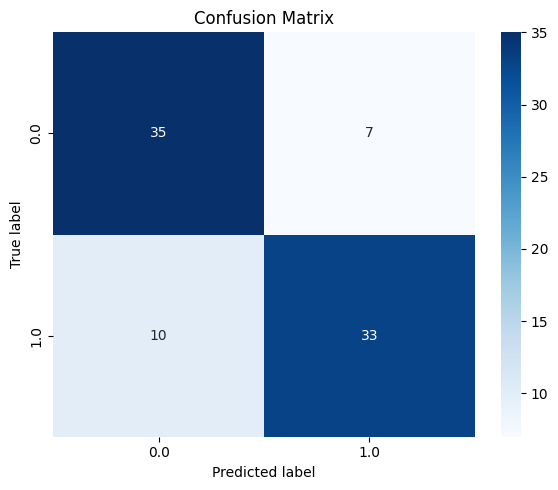


✅ Stability test finished. 5 rows of metrics collected.


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.856112,0.831104,0.745262,0.741391,0.484848,0.749020,0.741176
1,1,0.818237,0.850333,0.796840,0.798035,0.597156,0.807266,0.800000
2,42,0.949371,0.953735,0.868729,0.870444,0.738900,0.870542,0.870588
3,48,0.886987,0.860647,0.765050,0.765033,0.528040,0.766206,0.764706
4,2023,0.863640,0.877076,0.800388,0.799834,0.600277,0.801667,0.800000


In [36]:
# HDF
HDF = run_stability_test_metrics_only(data_types=['HDF'])
HDF

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.7610933780670166     │
│         val_loss          │    0.7610933780670166     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:19<00:00, 46.59s/it, Iteration=3, Best Loss=0.588]

[INFO] current best val loss: 0.5877668261528015; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4720373481887492, 'lr': 0.0021631151632029583, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


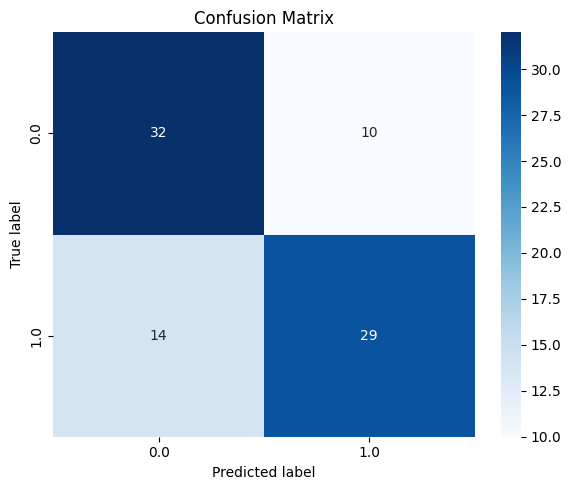


✅ Stability test finished. 5 rows of metrics collected.


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.804094,0.763657,0.660256,0.639945,0.310811,0.681854,0.647059
1,1,0.777014,0.760532,0.726996,0.727900,0.455886,0.731513,0.729412
2,42,0.856201,0.875139,0.792642,0.788411,0.578512,0.796471,0.788235
3,48,0.787020,0.804348,0.690078,0.693347,0.381645,0.693349,0.694118
4,2023,0.753041,0.791251,0.718162,0.717178,0.435841,0.719903,0.717647


In [37]:
# LD
LD = run_stability_test_metrics_only(data_types=['LD'])
LD

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.3600650429725647     │
│         val_loss          │    0.3600650429725647     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:21<00:00, 47.21s/it, Iteration=3, Best Loss=0.36] 

[INFO] current best val loss: 0.3600650429725647; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.472523602276015, 'lr': 0.002137505623646425, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


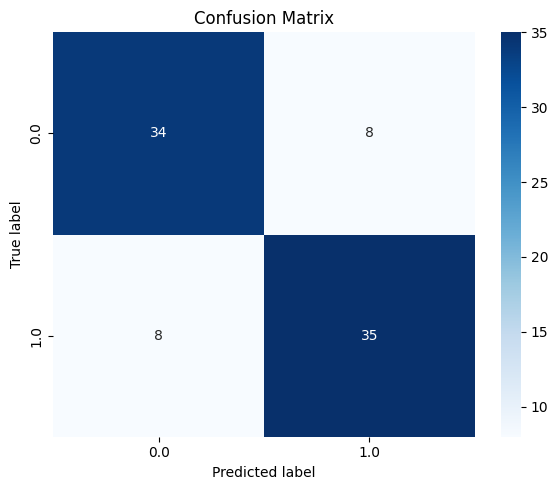


✅ Stability test finished. 5 rows of metrics collected.


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.886866,0.871795,0.799610,0.800167,0.598053,0.800556,0.800000
1,1,0.905341,0.897450,0.796009,0.796950,0.596481,0.812736,0.800000
2,42,0.970648,0.974916,0.907191,0.906013,0.811216,0.907148,0.905882
3,48,0.832522,0.846154,0.791806,0.797212,0.591693,0.805778,0.800000
4,2023,0.885603,0.894795,0.811739,0.811765,0.623477,0.811765,0.811765


In [38]:
# BM
BM = run_stability_test_metrics_only(data_types=['BM'])
BM

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.3380507230758667     │
│         val_loss          │    0.3380507230758667     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:17<00:00, 45.77s/it, Iteration=3, Best Loss=0.338]

[INFO] current best val loss: 0.3380507230758667; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47229446575954187, 'lr': 0.0021892180730040114, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


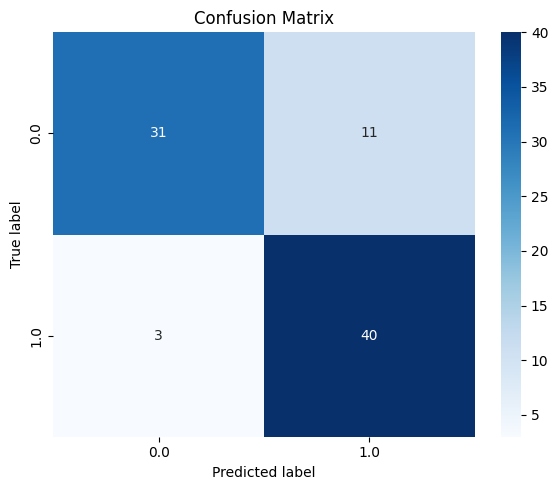


✅ Stability test finished. 5 rows of metrics collected.


In [39]:
# PM
PM = run_stability_test_metrics_only(data_types=['PM'])

# 2 blocks

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.5617693662643433     │
│         val_loss          │    0.5617693662643433     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:26<00:00, 48.71s/it, Iteration=3, Best Loss=0.465]

[INFO] current best val loss: 0.4646497964859009; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4727242853081264, 'lr': 0.002148027353748223, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


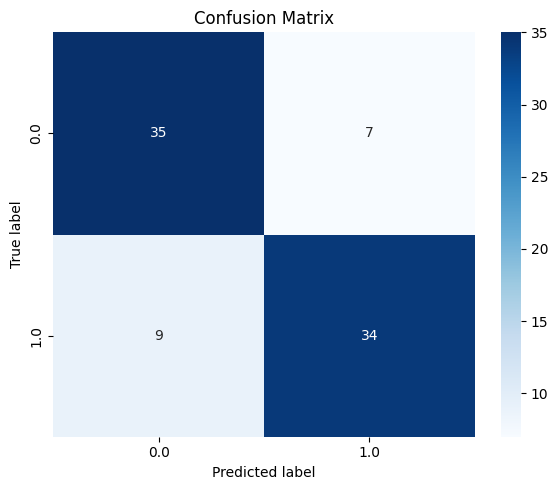


✅ Stability test finished. 5 rows of metrics collected.


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.902065,0.875139,0.803512,0.800277,0.601159,0.806098,0.800000
1,1,0.820282,0.860865,0.783814,0.784334,0.572387,0.803556,0.788235
2,42,0.946233,0.945931,0.877648,0.881624,0.761236,0.884908,0.882353
3,48,0.845428,0.852285,0.810479,0.811765,0.620959,0.811765,0.811765
4,2023,0.839933,0.873200,0.812016,0.811713,0.623686,0.812560,0.811765


In [41]:
# HDF_LD
HDF_LD = run_stability_test_metrics_only(data_types=['HDF','LD'])
HDF_LD

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.45647987723350525    │
│         val_loss          │    0.45647987723350525    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:17<00:00, 45.93s/it, Iteration=3, Best Loss=0.178]


[INFO] current best val loss: 0.17834293842315674; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47273743376872146, 'lr': 0.002100062579258576, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


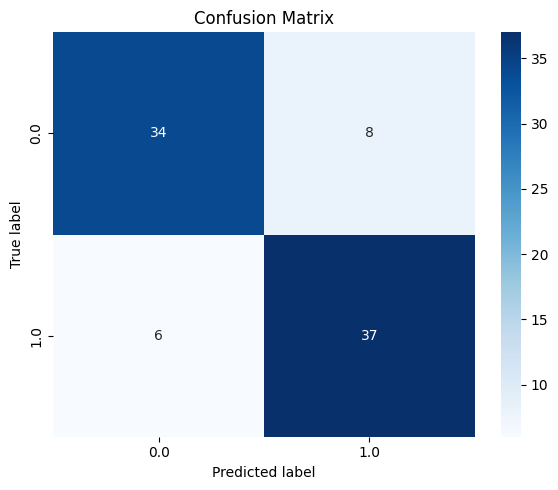


✅ Stability test finished. 5 rows of metrics collected.


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.933443,0.915831,0.806577,0.810599,0.617978,0.813109,0.811765
1,1,0.907434,0.899667,0.782982,0.782790,0.571669,0.811446,0.788235
2,42,0.948270,0.956522,0.905240,0.905882,0.810479,0.905882,0.905882
3,48,0.909166,0.894649,0.766165,0.771852,0.541844,0.785775,0.776471
4,2023,0.906697,0.915836,0.834994,0.835157,0.670360,0.835948,0.835294


In [42]:
# HDF_PM
# HDF_PM
HDF_PM = run_stability_test_metrics_only(data_types=['HDF', 'PM'])
HDF_PM

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.5302919149398804     │
│         val_loss          │    0.5302919149398804     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:12<00:00, 44.16s/it, Iteration=3, Best Loss=0.385]

[INFO] current best val loss: 0.38520723581314087; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47204485356802356, 'lr': 0.0020877640556306934, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


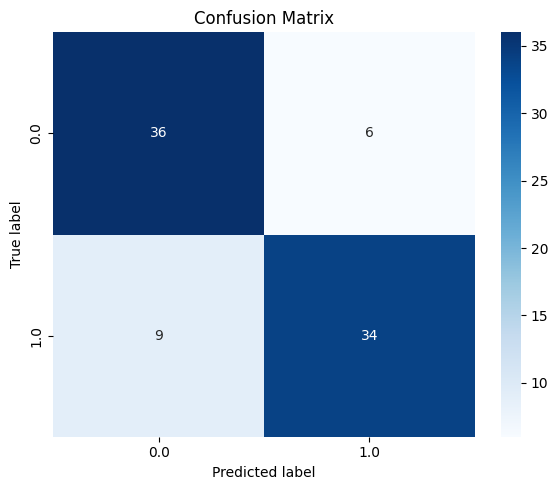


✅ Stability test finished. 5 rows of metrics collected.


In [43]:
# HDF_BM
HDF_BM = run_stability_test_metrics_only(data_types=['HDF', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.47575339674949646    │
│         val_loss          │    0.47575339674949646    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:27<00:00, 49.14s/it, Iteration=3, Best Loss=0.353]

[INFO] current best val loss: 0.3526991605758667; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47280000348176365, 'lr': 0.0021081816344679758, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


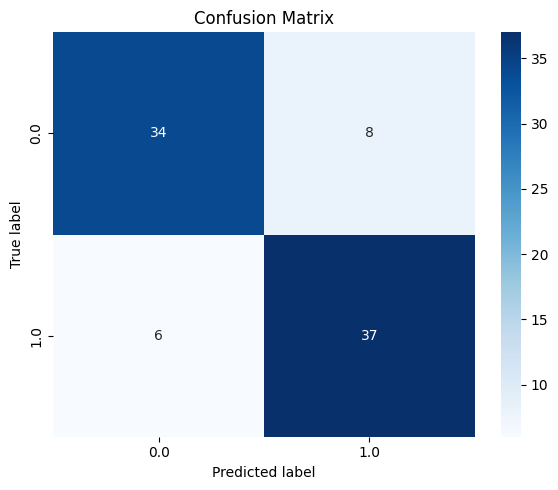


✅ Stability test finished. 5 rows of metrics collected.


In [44]:
# LD_PM
LD_PM = run_stability_test_metrics_only(data_types=['LD', 'PM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │     0.842000424861908     │
│         val_loss          │     0.842000424861908     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:23<00:00, 47.67s/it, Iteration=3, Best Loss=0.299]

[INFO] current best val loss: 0.29946470260620117; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4726196159269449, 'lr': 0.0021176305360010167, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


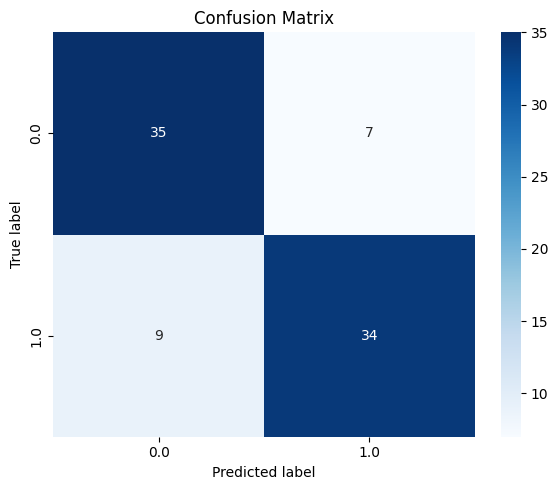


✅ Stability test finished. 5 rows of metrics collected.


In [45]:
# LD_BM
LD_BM = run_stability_test_metrics_only(data_types=['LD', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.39275166392326355    │
│         val_loss          │    0.39275166392326355    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:15<00:00, 45.28s/it, Iteration=3, Best Loss=0.393]

[INFO] current best val loss: 0.39275166392326355; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47201386213591284, 'lr': 0.0021276957628604868, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


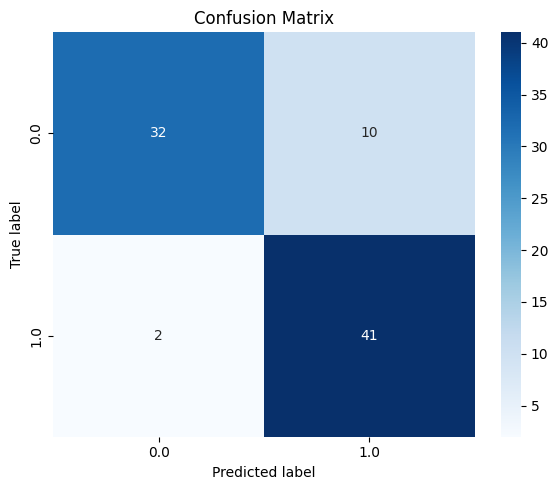


✅ Stability test finished. 5 rows of metrics collected.


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.948987,0.923634,0.832219,0.834879,0.667040,0.835400,0.835294
1,1,0.887357,0.879157,0.809035,0.810342,0.621170,0.817210,0.811765
2,42,0.972568,0.967113,0.932832,0.929529,0.858960,0.933763,0.929412
3,48,0.908270,0.904125,0.848105,0.855363,0.710063,0.877876,0.858824
4,2023,0.899246,0.914729,0.857697,0.857401,0.716981,0.871742,0.858824


In [46]:
# PM_BM
PM_BM = run_stability_test_metrics_only(data_types=['PM', 'BM'])
PM_BM

# 3 blocks

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.38815611600875854    │
│         val_loss          │    0.38815611600875854    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:31<00:00, 50.34s/it, Iteration=3, Best Loss=0.377]


[INFO] current best val loss: 0.3773041367530823; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4722367153058448, 'lr': 0.002175523702931272, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


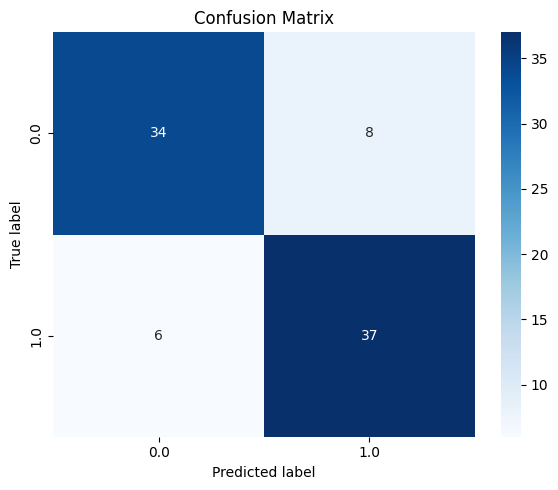


✅ Stability test finished. 5 rows of metrics collected.


In [48]:
# HDF_LD_PM
HDF_LD_PM = run_stability_test_metrics_only(data_types=['HDF', 'LD', 'PM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.2367929369211197     │
│         val_loss          │    0.2367929369211197     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:14<00:00, 44.98s/it, Iteration=3, Best Loss=0.237]


[INFO] current best val loss: 0.2367929369211197; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4725405526753889, 'lr': 0.0020892784412297406, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


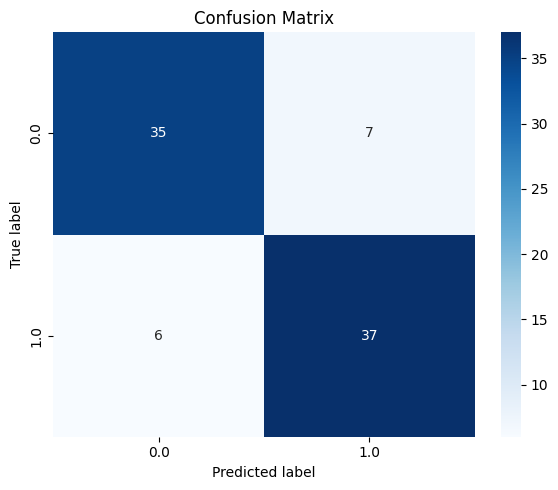


✅ Stability test finished. 5 rows of metrics collected.


In [49]:
# HDF_LD_BM
HDF_LD_BM = run_stability_test_metrics_only(data_types=['HDF', 'LD', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.21580803394317627    │
│         val_loss          │    0.21580803394317627    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:25<00:00, 48.36s/it, Iteration=3, Best Loss=0.216]


[INFO] current best val loss: 0.21580803394317627; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4722983377435875, 'lr': 0.002050771820828312, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


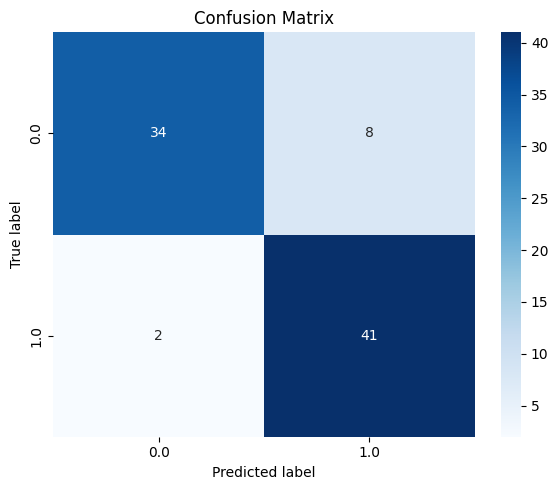


✅ Stability test finished. 5 rows of metrics collected.


In [50]:
# HDF_PM_BM
HDF_PM_BM = run_stability_test_metrics_only(data_types=['HDF', 'PM', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.4257151186466217     │
│         val_loss          │    0.4257151186466217     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:30<00:00, 50.02s/it, Iteration=3, Best Loss=0.301]

[INFO] current best val loss: 0.3013172745704651; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4728669410428305, 'lr': 0.0021475323085593102, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


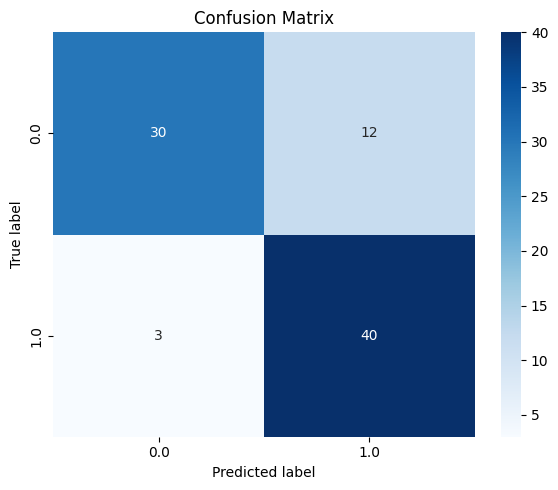


✅ Stability test finished. 5 rows of metrics collected.


In [51]:
# LD_PM_BM
LD_PM_BM = run_stability_test_metrics_only(data_types=['LD', 'PM', 'BM'])

# 4 blocks

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.42658674716949463    │
│         val_loss          │    0.42658674716949463    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:34<00:00, 51.56s/it, Iteration=3, Best Loss=0.296]

[INFO] current best val loss: 0.29641130566596985; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.4723157956445082, 'lr': 0.002116469554702151, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


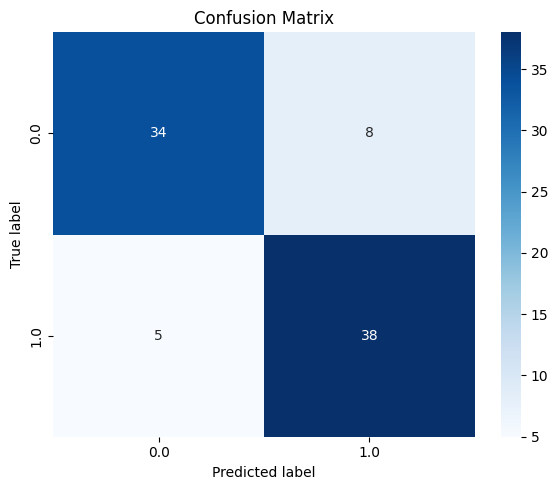


✅ Stability test finished. 5 rows of metrics collected.


In [53]:
# HDF_LD_PM_BM
HDF_LD_PM_BM = run_stability_test_metrics_only(data_types=['HDF', 'LD', 'PM', 'BM'])


In [54]:
HDF_LD_PM_BM

metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.943172,0.926421,0.855909,0.858468,0.714605,0.859075,0.858824
1,1,0.911545,0.910200,0.817905,0.818262,0.642757,0.855632,0.823529
2,42,0.941020,0.952062,0.894370,0.894206,0.787204,0.894542,0.894118
3,48,0.876929,0.887960,0.778986,0.784605,0.566818,0.795713,0.788235
4,2023,0.894930,0.921373,0.846622,0.846804,0.693821,0.848672,0.847059


In [55]:
LD_PM_BM

metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.931922,0.904682,0.802676,0.808538,0.614949,0.820536,0.811765
1,1,0.941574,0.931818,0.793514,0.792175,0.594443,0.841069,0.800000
2,42,0.947858,0.954849,0.872631,0.870804,0.740925,0.873187,0.870588
3,48,0.876743,0.875697,0.789855,0.795867,0.590071,0.810909,0.800000
4,2023,0.909430,0.924695,0.822259,0.821300,0.646128,0.838338,0.823529


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


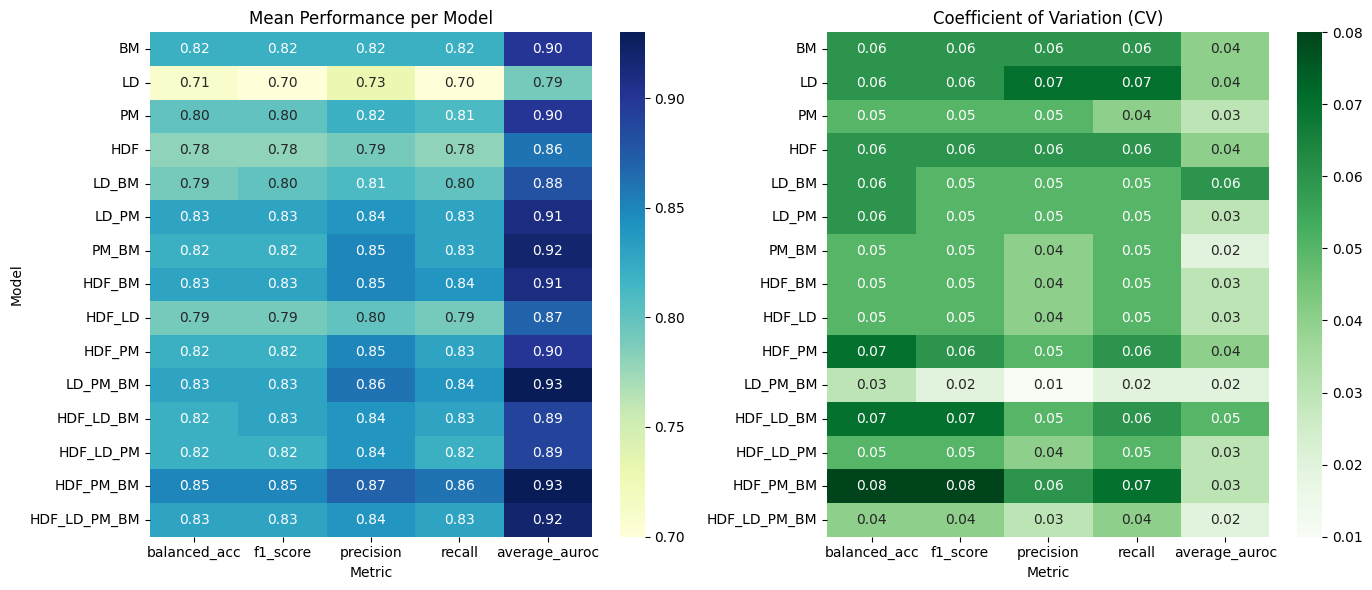

In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 读取文件夹中所有 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

# === 2. 加载所有文件到字典，并创建变量 ===
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 3. 指标列表（含 AUPR 和 AUROC）===
metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']

# === 4. 计算均值和 CV ===
mean_data = {}
cv_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    cv_data[name] = {}
    for metric in metrics:
        if metric in df.columns:
            values = df[metric]
            mean_val = values.mean()
            std_val = values.std()
            cv_val = std_val / mean_val if mean_val != 0 else np.nan
            mean_data[name][metric] = round(mean_val, 2)
            cv_data[name][metric] = round(cv_val, 2)
        else:
            mean_data[name][metric] = np.nan
            cv_data[name][metric] = np.nan

# === 5. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
cv_df = pd.DataFrame(cv_data).T

# ✅ 按模型名长度排序（可选）
sorted_index = sorted(mean_df.index, key=len)
mean_df = mean_df.loc[sorted_index]
cv_df = cv_df.loc[sorted_index]

# === 6. 可视化热图 ===
plt.figure(figsize=(14, 6))

# 热图 1：平均值
plt.subplot(1, 2, 1)
sns.heatmap(mean_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Mean Performance per Model")
plt.xlabel("Metric")
plt.ylabel("Model")

# 热图 2：CV
plt.subplot(1, 2, 2)
sns.heatmap(cv_df, annot=True, fmt=".2f", cmap="Greens")
plt.title("Coefficient of Variation (CV)")
plt.xlabel("Metric")
plt.ylabel("")

plt.tight_layout()
plt.show()


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


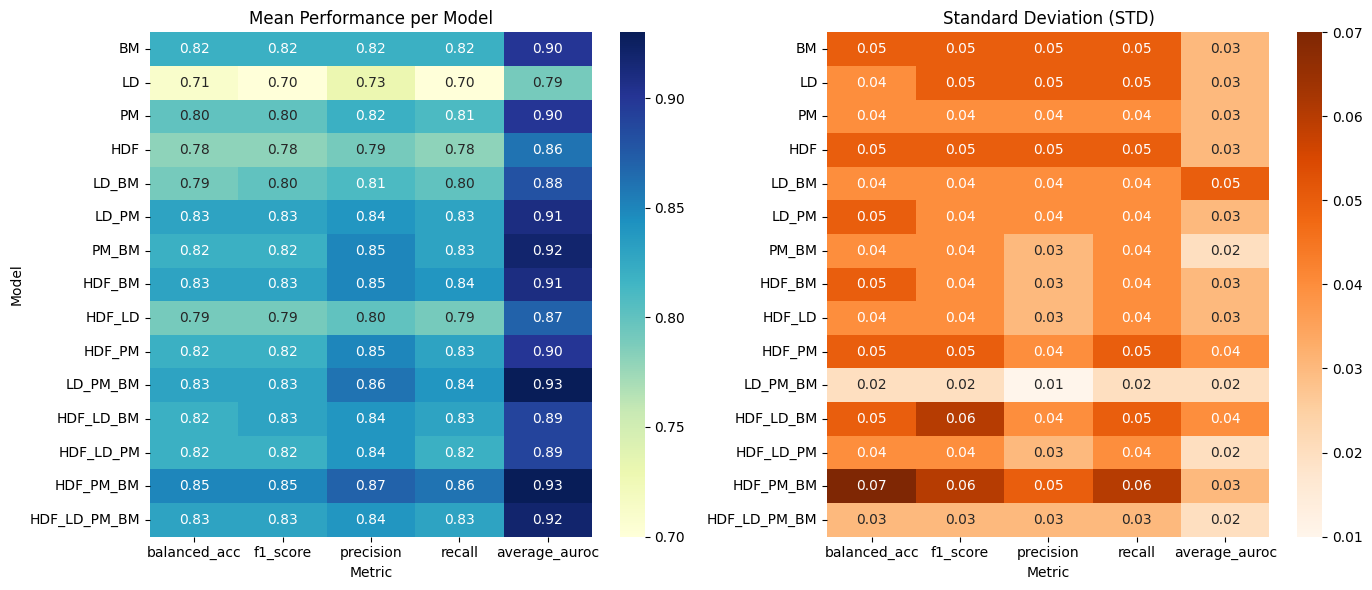

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 读取文件夹中所有 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

# === 2. 加载所有文件到字典，并创建变量 ===
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 3. 指标列表（含 AUPR 和 AUROC）===
metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']

# === 4. 计算均值和标准差（STD） ===
mean_data = {}
std_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    std_data[name] = {}
    for metric in metrics:
        if metric in df.columns:
            values = df[metric]
            mean_val = values.mean()
            std_val = values.std()
            mean_data[name][metric] = round(mean_val, 2)
            std_data[name][metric] = round(std_val, 2)
        else:
            mean_data[name][metric] = np.nan
            std_data[name][metric] = np.nan

# === 5. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
std_df = pd.DataFrame(std_data).T

# ✅ 按模型名长度排序（可选）
sorted_index = sorted(mean_df.index, key=len)
mean_df = mean_df.loc[sorted_index]
std_df = std_df.loc[sorted_index]

# === 6. 可视化热图 ===
plt.figure(figsize=(14, 6))

# 热图 1：平均值
plt.subplot(1, 2, 1)
sns.heatmap(mean_df, annot=True, fmt=".2f", cmap="YlGnBu", mask=mean_df.isna())
plt.title("Mean Performance per Model")
plt.xlabel("Metric")
plt.ylabel("Model")

# 热图 2：标准差 STD
plt.subplot(1, 2, 2)
sns.heatmap(std_df, annot=True, fmt=".2f", cmap="Oranges", mask=std_df.isna())
plt.title("Standard Deviation (STD)")
plt.xlabel("Metric")
plt.ylabel("")

plt.tight_layout()
plt.show()


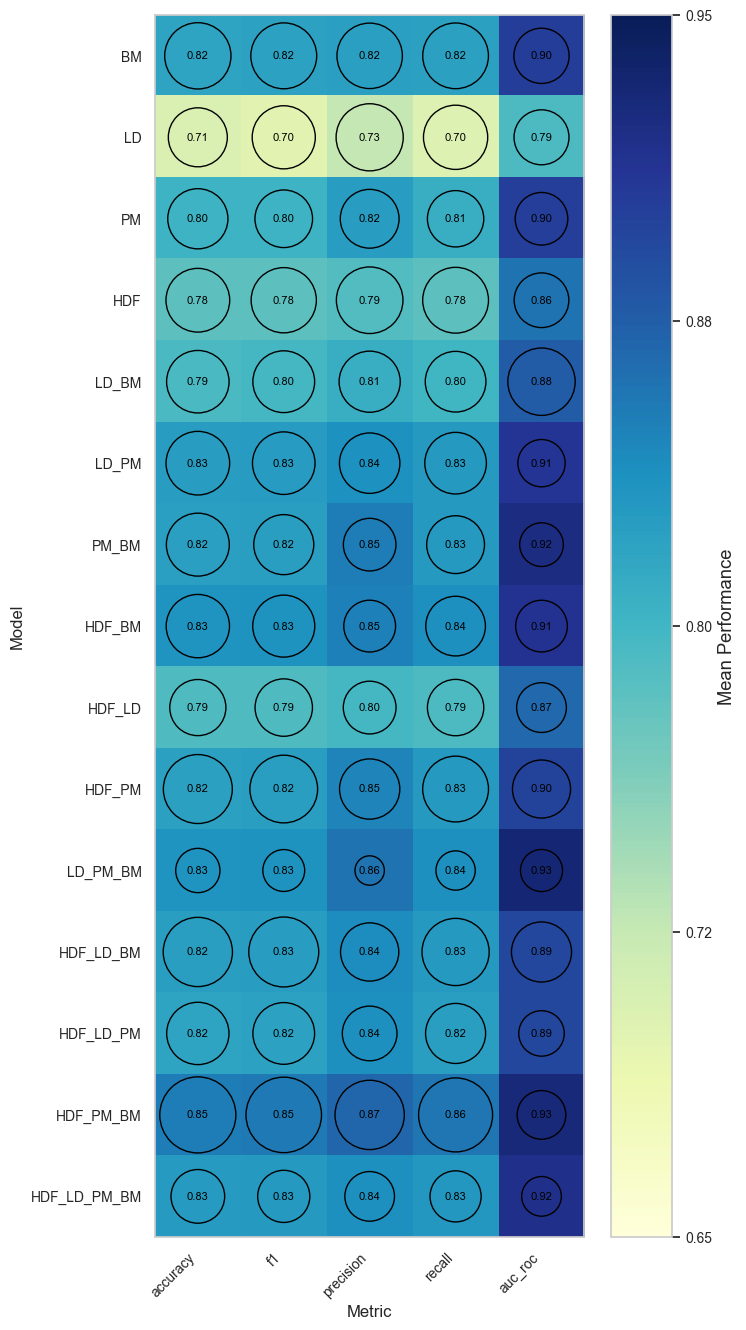

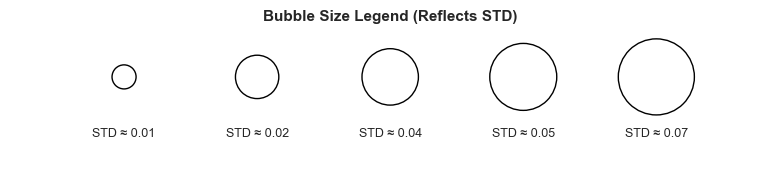

In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. 读取 CSV 文件夹 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
output_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 指标列名（不含specificity）
metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']

# === 2. 加载 CSV 并计算 mean/std ===
mean_data = {}
std_data = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    model_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)

    mean_data[model_name] = {}
    std_data[model_name] = {}
    for metric in metrics:
        if metric in df.columns:
            values = df[metric].dropna()
            mean_data[model_name][metric] = values.mean()
            std_data[model_name][metric] = values.std()
        else:
            mean_data[model_name][metric] = np.nan
            std_data[model_name][metric] = np.nan

# === 3. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
std_df = pd.DataFrame(std_data).T

# 排序模型名（可选）
sorted_index = sorted(mean_df.index, key=len)
mean_df = mean_df.loc[sorted_index]
std_df = std_df.loc[sorted_index]

# === 4. 主图函数 ===
def plot_bioinfo_style(mean_df, std_df, max_circle_size=3000, cmap='YlGnBu'):
    import matplotlib.ticker as mticker

    labels = mean_df.index.tolist()
    metrics = mean_df.columns.tolist()

    display_names_map = {
        'balanced_acc': 'accuracy',
        'f1_score': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'average_auroc': 'auc_roc'
    }
    display_names = [display_names_map.get(m, m) for m in metrics]

    mean_matrix = mean_df.to_numpy()
    std_matrix = std_df.to_numpy()

    vmin, vmax = 0.65, 0.95
    max_std = np.nanmax(std_matrix)
    sizes = (std_matrix / max_std) * max_circle_size

    n_rows, n_cols = mean_matrix.shape

    fig, ax = plt.subplots(figsize=(n_cols * 1.5, n_rows * 0.9))
    cax = ax.imshow(mean_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cax, ax=ax, label='Mean Performance')
    cbar.set_ticks(np.linspace(vmin, vmax, num=5))
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    ax.set_xticks(np.arange(n_cols))
    ax.set_xticklabels(display_names, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(labels, fontsize=10)
    ax.grid(False)

    for i in range(n_rows):
        for j in range(n_cols):
            val = mean_matrix[i, j]
            size = sizes[i, j]
            if not np.isnan(val):
                ax.scatter(j, i, s=size, facecolors='none', edgecolors='black', linewidths=1)
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color='black')

    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    plt.tight_layout()

    # 保存图像
    output_path = os.path.join(output_folder, 'MeanPerformance_flexynesis.png')
    fig.savefig(output_path, dpi=300)
    plt.show()

    return max_std, max_circle_size

# === 5. 图例函数 ===
def plot_std_legend(max_std, max_circle_size):
    fig, ax = plt.subplots(figsize=(8, 2))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    example_std = np.linspace(0.1 * max_std, max_std, 5)
    example_sizes = (example_std / max_std) * max_circle_size
    x_pos = np.linspace(0.15, 0.85, 5)

    for x, size, std_val in zip(x_pos, example_sizes, example_std):
        ax.scatter(x, 0.65, s=size, facecolors='none', edgecolors='black', linewidths=1)
        ax.text(x, 0.25, f'STD ≈ {std_val:.2f}', ha='center', va='center', fontsize=9)

    ax.text(0.5, 1.05, "Bubble Size Legend (Reflects STD)", ha='center', fontsize=11, fontweight='bold')
    plt.tight_layout()

    # 保存图例图像
    output_path = os.path.join(output_folder, 'STD_Legend_flexynesis.png')
    fig.savefig(output_path, dpi=300)
    plt.show()

# === 6. 执行绘图并保存 ===
max_std, max_circle_size = plot_bioinfo_style(mean_df, std_df)
plot_std_legend(max_std, max_circle_size)


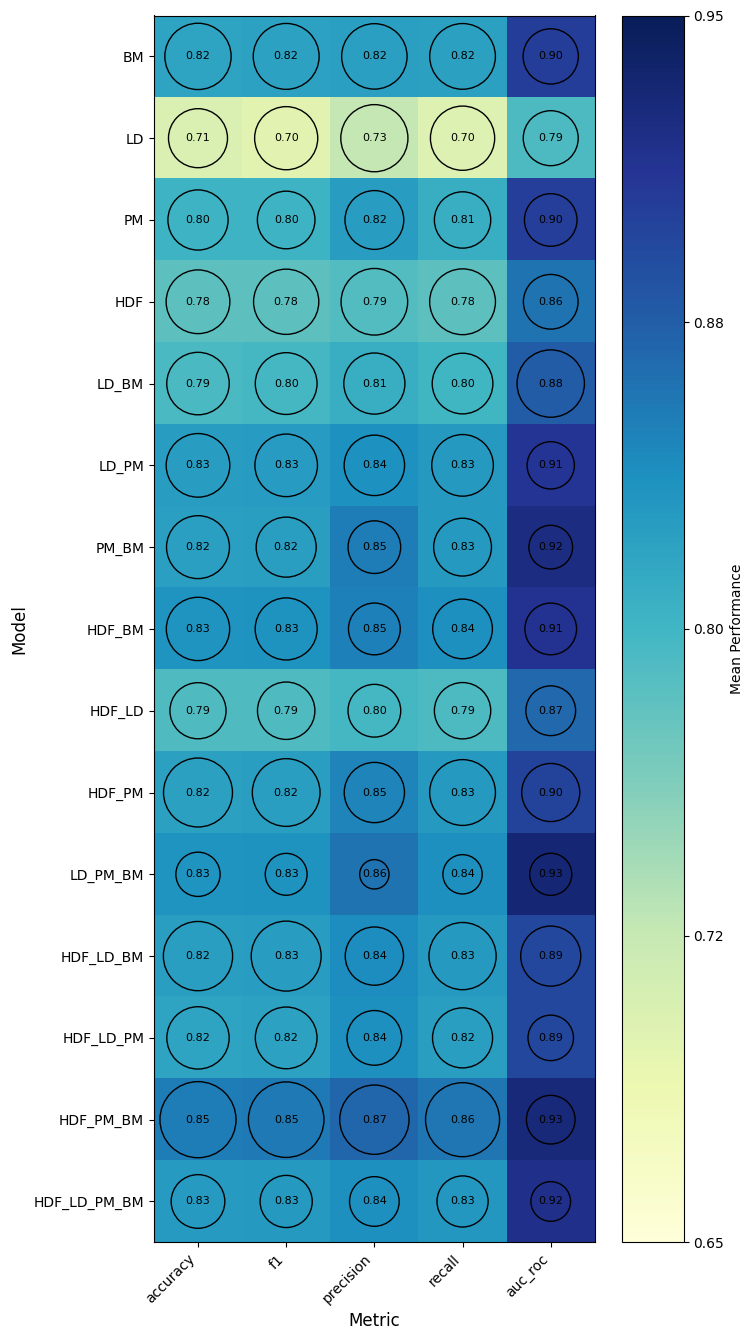

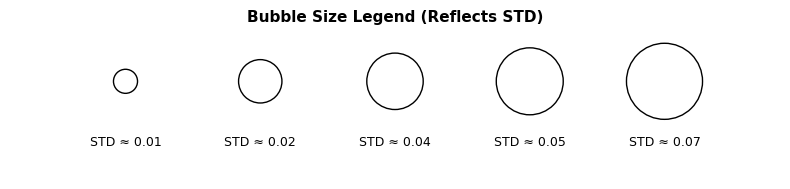

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. 读取 CSV 文件夹 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
output_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 指标列名（不含specificity）
metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']

# === 2. 加载 CSV 并计算 mean/std ===
mean_data = {}
std_data = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    model_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)

    mean_data[model_name] = {}
    std_data[model_name] = {}
    for metric in metrics:
        if metric in df.columns:
            values = df[metric].dropna()
            mean_data[model_name][metric] = values.mean()
            std_data[model_name][metric] = values.std()
        else:
            mean_data[model_name][metric] = np.nan
            std_data[model_name][metric] = np.nan

# === 3. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
std_df = pd.DataFrame(std_data).T

# 排序模型名（可选）
sorted_index = sorted(mean_df.index, key=len)
mean_df = mean_df.loc[sorted_index]
std_df = std_df.loc[sorted_index]

# === 4. 主图函数 ===
def plot_bioinfo_style(mean_df, std_df, max_circle_size=3000, cmap='YlGnBu'):
    import matplotlib.ticker as mticker

    labels = mean_df.index.tolist()
    metrics = mean_df.columns.tolist()

    display_names_map = {
        'balanced_acc': 'accuracy',
        'f1_score': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'average_auroc': 'auc_roc'
    }
    display_names = [display_names_map.get(m, m) for m in metrics]

    mean_matrix = mean_df.to_numpy()
    std_matrix = std_df.to_numpy()

    vmin, vmax = 0.65, 0.95
    max_std = np.nanmax(std_matrix)
    sizes = (std_matrix / max_std) * max_circle_size

    n_rows, n_cols = mean_matrix.shape

    fig, ax = plt.subplots(figsize=(n_cols * 1.5, n_rows * 0.9))
    cax = ax.imshow(mean_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cax, ax=ax, label='Mean Performance')
    cbar.set_ticks(np.linspace(vmin, vmax, num=5))
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    ax.set_xticks(np.arange(n_cols))
    ax.set_xticklabels(display_names, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(labels, fontsize=10)
    ax.grid(False)

    for i in range(n_rows):
        for j in range(n_cols):
            val = mean_matrix[i, j]
            size = sizes[i, j]
            if not np.isnan(val):
                ax.scatter(j, i, s=size, facecolors='none', edgecolors='black', linewidths=1)
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=8, color='black')

    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    plt.tight_layout()

    # 保存图像
    output_path = os.path.join(output_folder, 'MeanPerformance_flexynesis.png')
    fig.savefig(output_path, dpi=300)
    plt.show()

    return max_std, max_circle_size

# === 5. 图例函数 ===
def plot_std_legend(max_std, max_circle_size):
    fig, ax = plt.subplots(figsize=(8, 2))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    example_std = np.linspace(0.1 * max_std, max_std, 5)
    example_sizes = (example_std / max_std) * max_circle_size
    x_pos = np.linspace(0.15, 0.85, 5)

    for x, size, std_val in zip(x_pos, example_sizes, example_std):
        ax.scatter(x, 0.65, s=size, facecolors='none', edgecolors='black', linewidths=1)
        ax.text(x, 0.25, f'STD ≈ {std_val:.2f}', ha='center', va='center', fontsize=9)

    ax.text(0.5, 1.05, "Bubble Size Legend (Reflects STD)", ha='center', fontsize=11, fontweight='bold')
    plt.tight_layout()

    # 保存图例图像
    output_path = os.path.join(output_folder, 'STD_Legend_flexynesis.png')
    fig.savefig(output_path, dpi=300)
    plt.show()

# === 6. 执行绘图并保存 ===
max_std, max_circle_size = plot_bioinfo_style(mean_df, std_df)
plot_std_legend(max_std, max_circle_size)


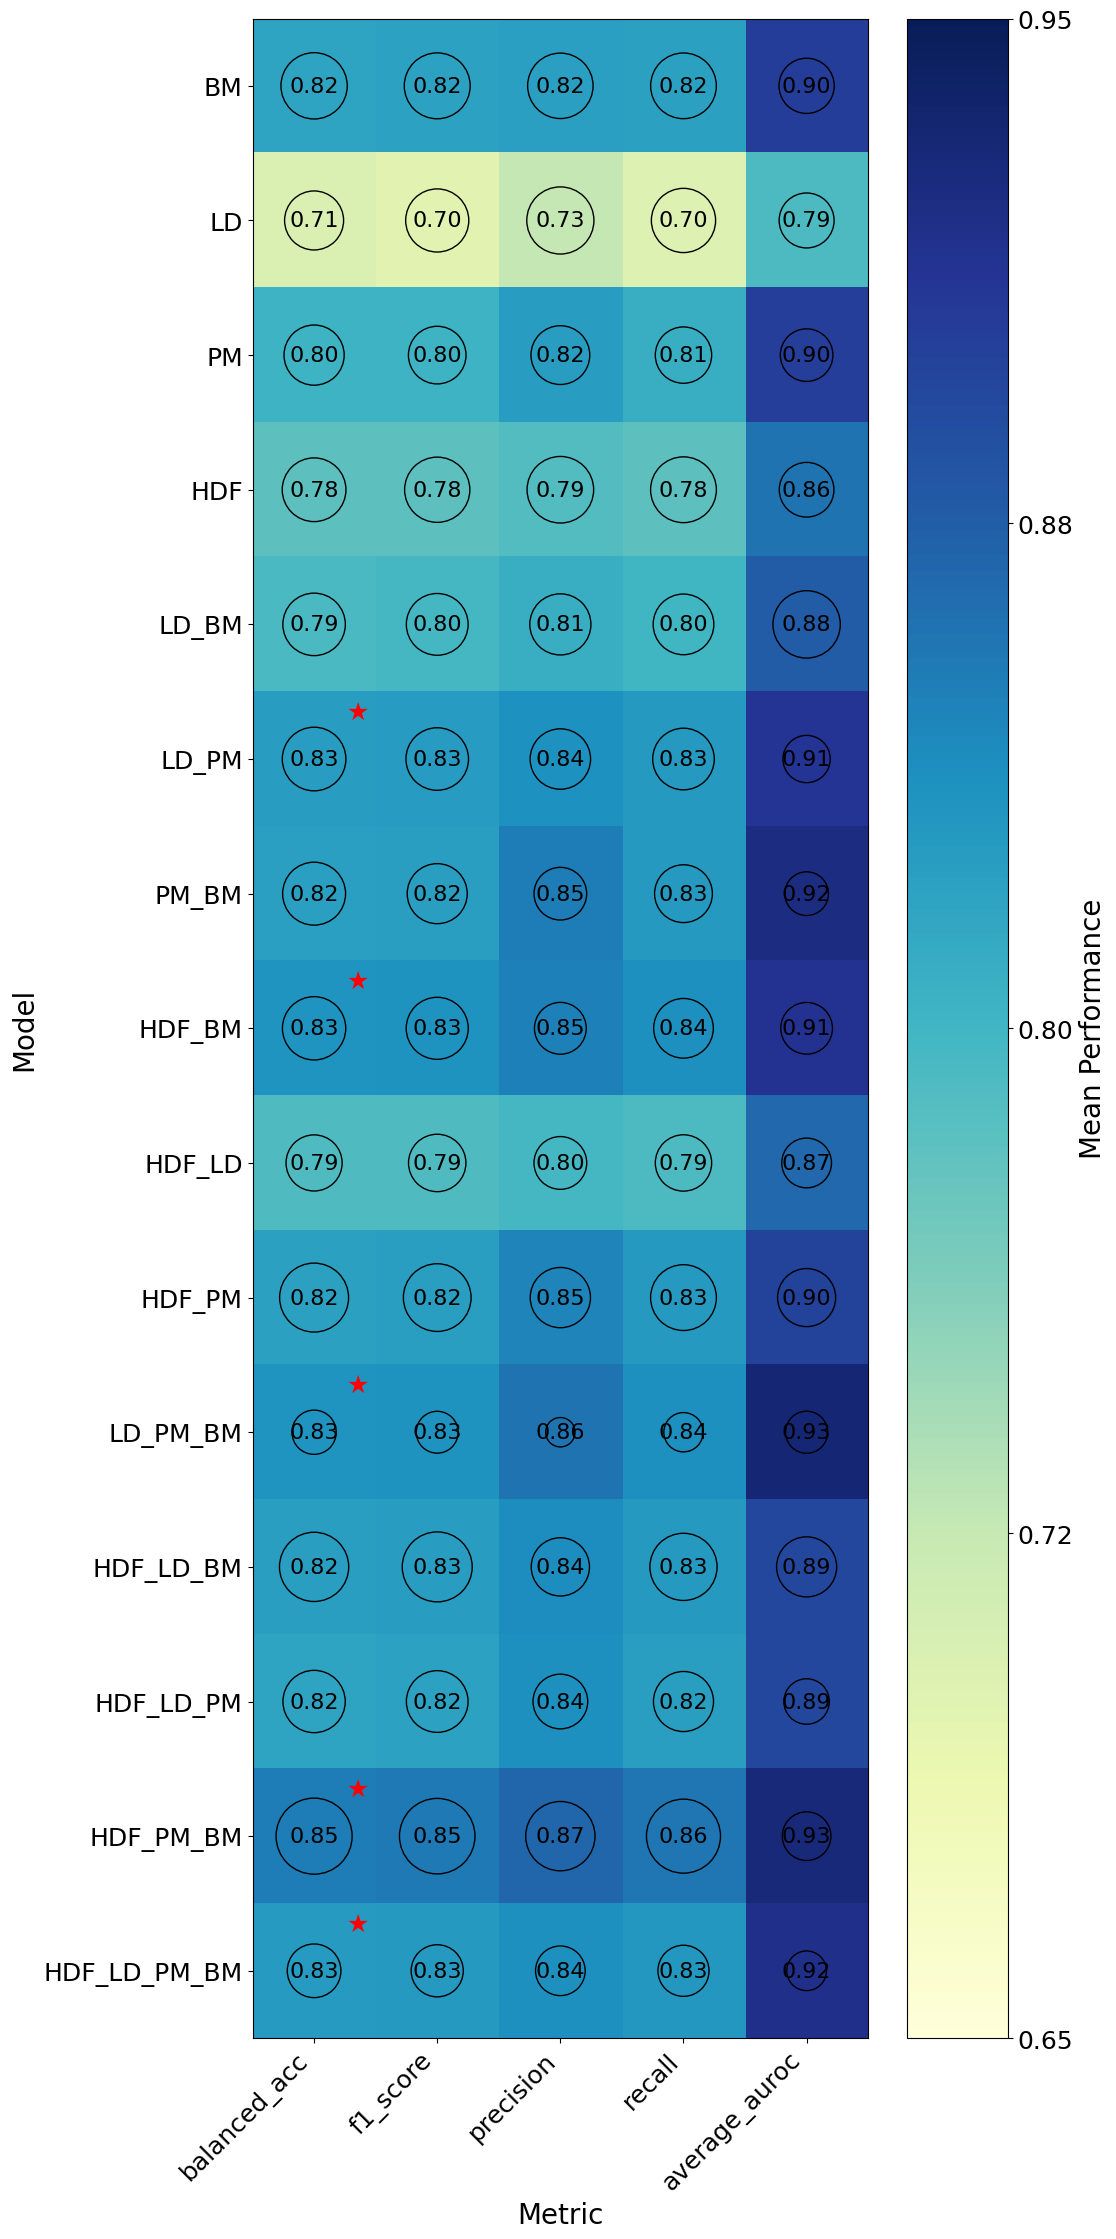

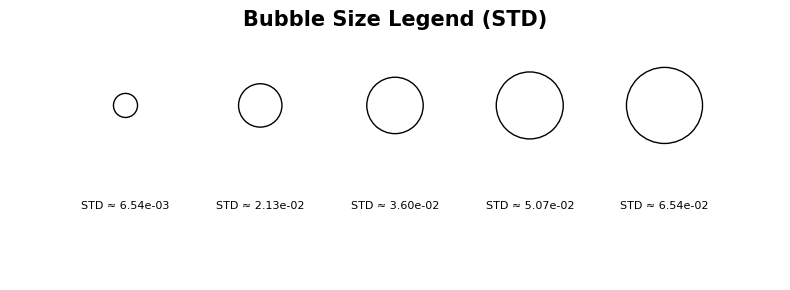

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os

def plot_ci_heatmap_flexynesis(mean_df, std_df, max_circle_size=3000, cmap='YlGnBu'):
    labels = mean_df.index.tolist()
    metrics = mean_df.columns.tolist()

    mean_matrix = mean_df.to_numpy()
    std_matrix = std_df.to_numpy()

    vmin, vmax = 0.65, 0.95
    max_std = np.nanmax(std_matrix)
    sizes = (std_matrix / max_std) * max_circle_size

    n_rows, n_cols = mean_matrix.shape
    fig, ax = plt.subplots(figsize=(n_cols * 2.2, n_rows * 1.5))  # 大画布

    cax = ax.imshow(mean_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_ticks(np.linspace(vmin, vmax, num=5))
    cbar.ax.tick_params(labelsize=18)
    cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    cbar.set_label('Mean Performance', fontsize=20)

    ax.set_xticks(np.arange(n_cols))
    ax.set_xticklabels(metrics, rotation=45, ha='right', fontsize=18)
    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(labels, fontsize=18)

    for i in range(n_rows):
        for j in range(n_cols):
            val = mean_matrix[i, j]
            size = sizes[i, j]
            if not np.isnan(val):
                # 画圆圈
                ax.scatter(j, i, s=size, facecolors='none', edgecolors='black', linewidths=1)
                # 数值文本
                ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=16, color='black')

                # 五角星标注 accuracy >= 0.83
                if metrics[j] == 'balanced_acc' and round(val, 2) >= 0.83:
                    ax.text(j + 0.35, i - 0.35, '★', fontsize=18, color='red', ha='center', va='center')

    ax.set_xlabel('Metric', fontsize=20)
    ax.set_ylabel('Model', fontsize=20)
    ax.tick_params(axis='both', labelsize=18)

    plt.tight_layout()

    # 保存路径（flexynesis文件夹）
    output_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
    output_path = os.path.join(output_folder, 'MeanPerformance_Std_Heatmap_Flexynesis.png')
    fig.savefig(output_path, dpi=300)
    plt.show()

    return max_std, max_circle_size

def plot_std_legend_flexynesis(max_std, max_circle_size):
    fig, ax = plt.subplots(figsize=(8, 3))  # 高一点

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    example_std = np.linspace(0.1 * max_std, max_std, 5)
    example_sizes = (example_std / max_std) * max_circle_size
    x_pos = np.linspace(0.15, 0.85, 5)

    for x, size, std_val in zip(x_pos, example_sizes, example_std):
        ax.scatter(x, 0.7, s=size, facecolors='none', edgecolors='black', linewidths=1)
        ax.text(x, 0.3, f'STD ≈ {std_val:.2e}', ha='center', va='center', fontsize=8)

    ax.text(0.5, 1.02, "Bubble Size Legend (STD)", ha='center', fontsize=15, fontweight='bold')

    plt.tight_layout()

    output_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"
    output_path = os.path.join(output_folder, 'STD_Legend_Flexynesis.png')
    fig.savefig(output_path, dpi=300)
    plt.show()

# 调用示例
max_std, max_circle_size = plot_ci_heatmap_flexynesis(mean_df, std_df)
plot_std_legend_flexynesis(max_std, max_circle_size)


In [19]:
model_name = 'HDF_LD_PM_BM'
metric_name = 'accuracy'

model_index = mean_df.index.tolist().index(model_name)
metric_index = mean_df.columns.tolist().index(metric_name)

mean_val = mean_df.iloc[model_index, metric_index]
std_val = std_df.iloc[model_index, metric_index]

lower_bound = mean_val - std_val
upper_bound = mean_val + std_val

print(f"{model_name} 的 {metric_name} = {mean_val:.4f} ± {std_val:.4f}")
print(f"{metric_name} 波动范围为: [{lower_bound:.4f}, {upper_bound:.4f}]")


HDF_LD_PM_BM 的 accuracy = 0.8300 ± 0.0448
accuracy 波动范围为: [0.7852, 0.8748]


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


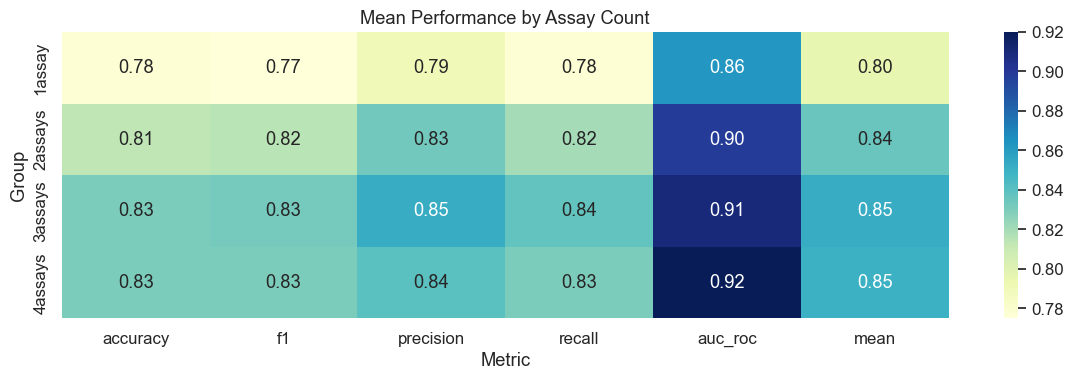

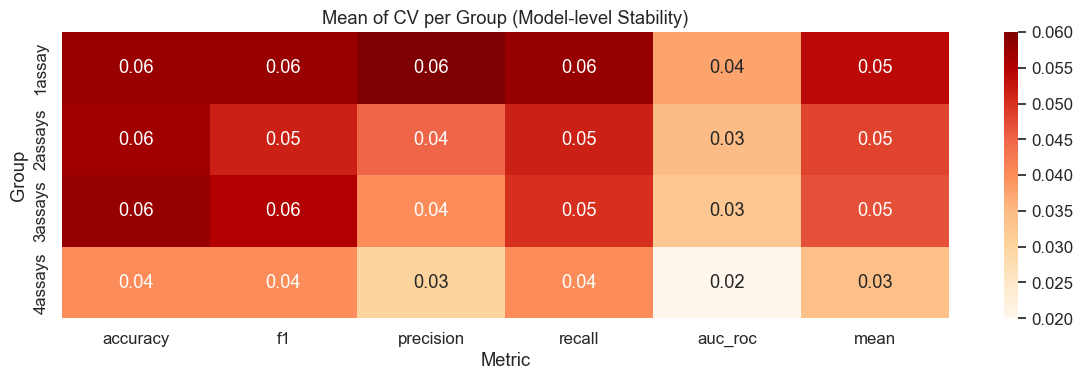

C:\Users\laura\AppData\Local\Temp\ipykernel_32496\246543893.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  within_group_cv_df.replace('-', np.nan),


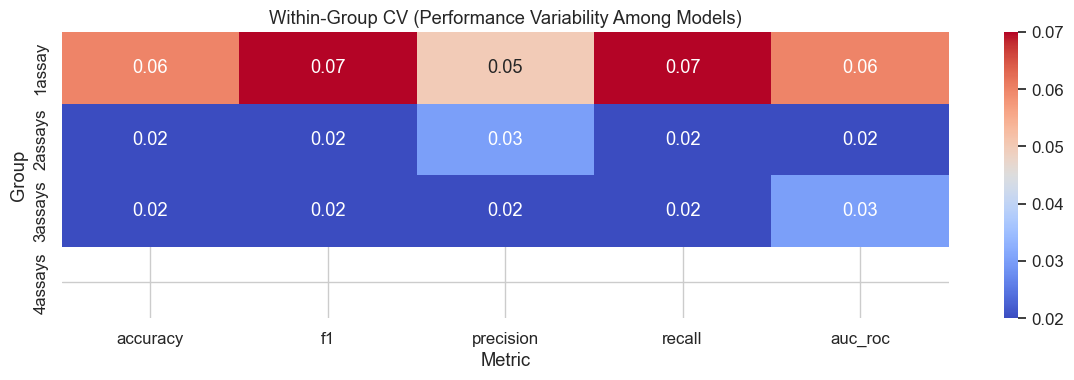

✅ 所有图已保存并显示！


In [85]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 加载 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 2. 原始指标名 & 映射到标准名 ===
original_metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']
rename_map = {
    'balanced_acc': 'accuracy',
    'f1_score': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_auroc': 'auc_roc'
}
metrics = [rename_map[m] for m in original_metrics]

# === 3. 计算均值和CV ===
mean_data = {}
cv_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    cv_data[name] = {}
    for ori_metric in original_metrics:
        if ori_metric in df.columns:
            values = df[ori_metric]
            mean_val = values.mean()
            std_val = values.std()
            cv_val = std_val / mean_val if mean_val != 0 else np.nan
            std_name = rename_map[ori_metric]
            mean_data[name][std_name] = round(mean_val, 2)
            cv_data[name][std_name] = round(cv_val, 2)
        else:
            std_name = rename_map[ori_metric]
            mean_data[name][std_name] = np.nan
            cv_data[name][std_name] = np.nan

# === 4. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
cv_df = pd.DataFrame(cv_data).T

# === 5. 分组 ===
assay_groups = {}
for model_name in mean_df.index:
    assay_count = model_name.count('_') + 1
    group_key = f"{assay_count}assay" if assay_count == 1 else f"{assay_count}assays"
    assay_groups.setdefault(group_key, []).append(model_name)

# === 6. 计算 group mean 和 group CV ===
group_mean_df = pd.DataFrame(columns=metrics)
group_avg_cv_df = pd.DataFrame(columns=metrics)

for group_name, model_list in assay_groups.items():
    selected_mean = mean_df.loc[model_list]
    group_mean_df.loc[group_name] = selected_mean.mean()
    selected_cv = cv_df.loc[model_list]
    group_avg_cv_df.loc[group_name] = selected_cv.mean()

# === 7. 添加 mean 列 ===
group_mean_df['mean'] = group_mean_df.mean(axis=1)
group_avg_cv_df['mean'] = group_avg_cv_df.mean(axis=1)

# === 8. 组内差异 CV（模型之间） ===
within_group_cv_df = pd.DataFrame(columns=metrics)
for group_name, model_list in assay_groups.items():
    if len(model_list) <= 1:
        within_group_cv_df.loc[group_name] = ['-' for _ in metrics]
        continue
    selected_means = mean_df.loc[model_list]
    group_cv = selected_means.std() / selected_means.mean()
    within_group_cv_df.loc[group_name] = group_cv.round(2)

# === 9. 可视化并保存并显示 ===
fig_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"

# 图1：Mean Performance
plt.figure(figsize=(12, 4))
sns.heatmap(group_mean_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Mean Performance by Assay Count')
plt.xlabel("Metric")
plt.ylabel("Group")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_mean_performance_flexynesis.png"), dpi=300)
plt.show()  # 显示图像

# 图2：CV per group（模型稳定性）
plt.figure(figsize=(12, 4))
sns.heatmap(group_avg_cv_df, annot=True, cmap='OrRd', fmt=".2f")
plt.title('Mean of CV per Group (Model-level Stability)')
plt.xlabel("Metric")
plt.ylabel("Group")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_model_stability_cv_flexynesis.png"), dpi=300)
plt.show()  # 显示图像

# 图3：组内差异 CV（模型间差异）
plt.figure(figsize=(12, 4))
sns.heatmap(
    within_group_cv_df.replace('-', np.nan),
    annot=within_group_cv_df,
    cmap='coolwarm',
    fmt='',
)
plt.title('Within-Group CV (Performance Variability Among Models)')
plt.xlabel("Metric")
plt.ylabel("Group")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_within_variability_cv_flexynesis.png"), dpi=300)
plt.show()  # 显示图像

print("✅ 所有图已保存并显示！")


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


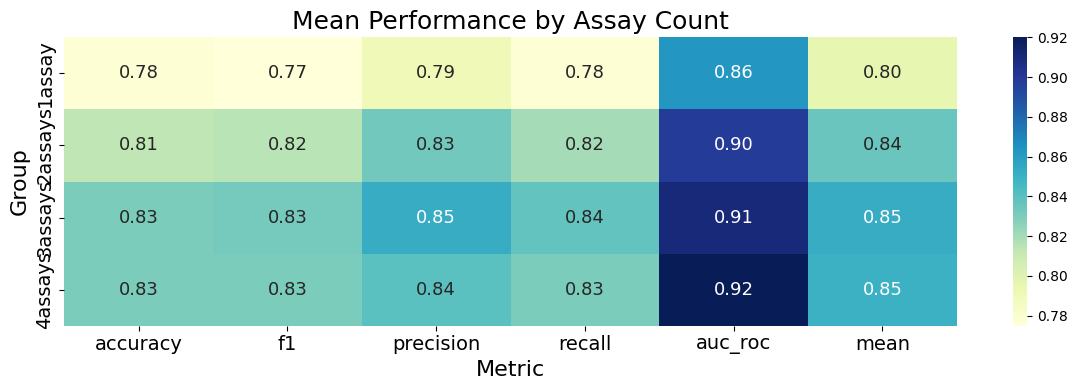

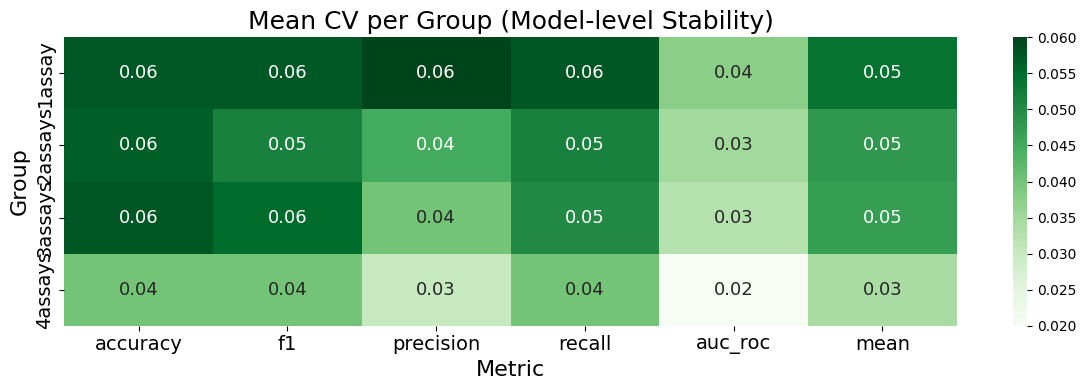

C:\Users\laura\AppData\Local\Temp\ipykernel_55912\2671228260.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  within_group_cv_df.replace('-', np.nan),


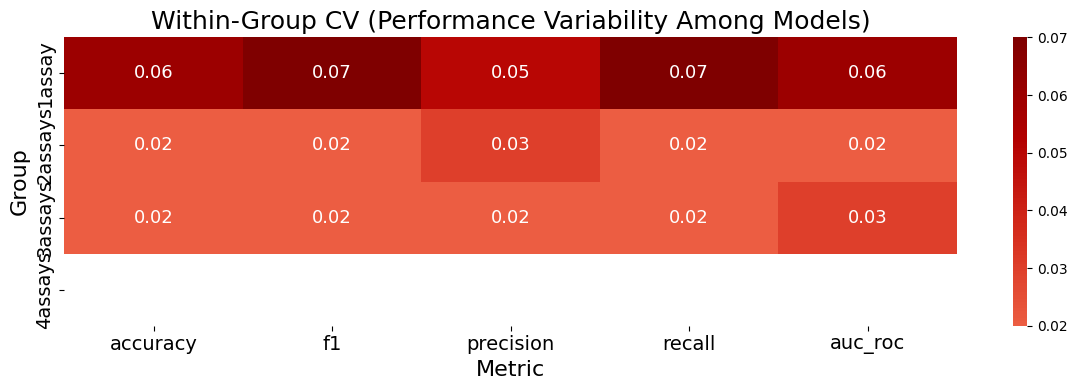

✅ 所有图已保存并显示！


In [11]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 加载 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 2. 原始指标名 & 映射到标准名 ===
original_metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']
rename_map = {
    'balanced_acc': 'accuracy',
    'f1_score': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_auroc': 'auc_roc'
}
metrics = [rename_map[m] for m in original_metrics]

# === 3. 计算均值和CV ===
mean_data = {}
cv_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    cv_data[name] = {}
    for ori_metric in original_metrics:
        if ori_metric in df.columns:
            values = df[ori_metric]
            mean_val = values.mean()
            std_val = values.std()
            cv_val = std_val / mean_val if mean_val != 0 else np.nan
            std_name = rename_map[ori_metric]
            mean_data[name][std_name] = round(mean_val, 2)
            cv_data[name][std_name] = round(cv_val, 2)
        else:
            std_name = rename_map[ori_metric]
            mean_data[name][std_name] = np.nan
            cv_data[name][std_name] = np.nan

# === 4. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
cv_df = pd.DataFrame(cv_data).T

# === 5. 分组 ===
assay_groups = {}
for model_name in mean_df.index:
    assay_count = model_name.count('_') + 1
    group_key = f"{assay_count}assay" if assay_count == 1 else f"{assay_count}assays"
    assay_groups.setdefault(group_key, []).append(model_name)

# === 6. 计算 group mean 和 group CV ===
group_mean_df = pd.DataFrame(columns=metrics)
group_avg_cv_df = pd.DataFrame(columns=metrics)

for group_name, model_list in assay_groups.items():
    selected_mean = mean_df.loc[model_list]
    group_mean_df.loc[group_name] = selected_mean.mean()
    selected_cv = cv_df.loc[model_list]
    group_avg_cv_df.loc[group_name] = selected_cv.mean()

# === 7. 添加 mean 列 ===
group_mean_df['mean'] = group_mean_df.mean(axis=1)
group_avg_cv_df['mean'] = group_avg_cv_df.mean(axis=1)

# === 8. 组内差异 CV（模型之间） ===
within_group_cv_df = pd.DataFrame(columns=metrics)
for group_name, model_list in assay_groups.items():
    if len(model_list) <= 1:
        within_group_cv_df.loc[group_name] = ['-' for _ in metrics]
        continue
    selected_means = mean_df.loc[model_list]
    group_cv = selected_means.std() / selected_means.mean()
    within_group_cv_df.loc[group_name] = group_cv.round(2)

# === 9. 可视化并保存并显示 ===
fig_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"

# === 图1：组均值热力图 ===
plt.figure(figsize=(12, 4))
sns.heatmap(group_mean_df, annot=True, cmap='YlGnBu', fmt=".2f", annot_kws={"size":13})
plt.title('Mean Performance by Assay Count', fontsize=18)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Group", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_mean_performance_flexynesis.png"), dpi=300)
plt.show()

# === 图2：平均CV热力图 ===
plt.figure(figsize=(12, 4))
sns.heatmap(group_avg_cv_df, annot=True, cmap='Greens', fmt=".2f", annot_kws={"size":13})
plt.title('Mean CV per Group (Model-level Stability)', fontsize=18)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Group", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_model_stability_cv_flexynesis.png"), dpi=300)
plt.show()

# === 图3：组内模型变异CV（模型间） ===
plt.figure(figsize=(12, 4))
sns.heatmap(
    within_group_cv_df.replace('-', np.nan),
    annot=within_group_cv_df.replace('-', ''),
    cmap='OrRd',
    fmt='.2f',
    center=0,
    annot_kws={"size":13}
)
plt.title('Within-Group CV (Performance Variability Among Models)', fontsize=18)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Group", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_within_variability_cv_flexynesis_green.png"), dpi=300)
plt.show()

print("✅ 所有图已保存并显示！")


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


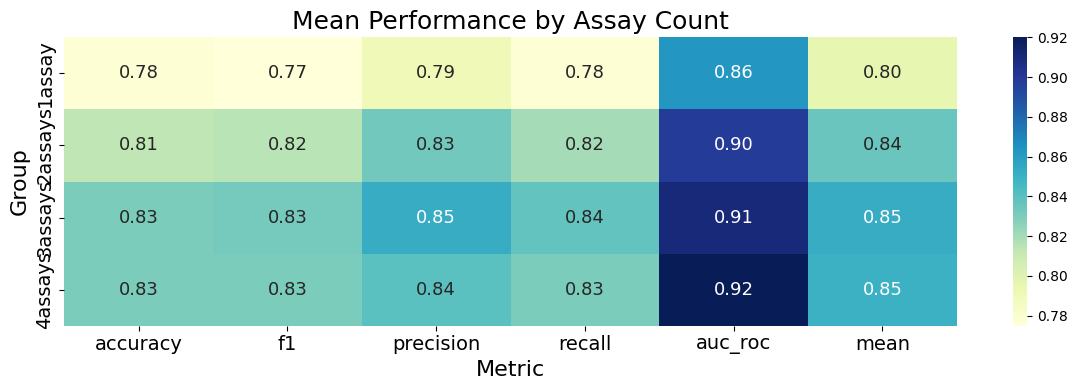

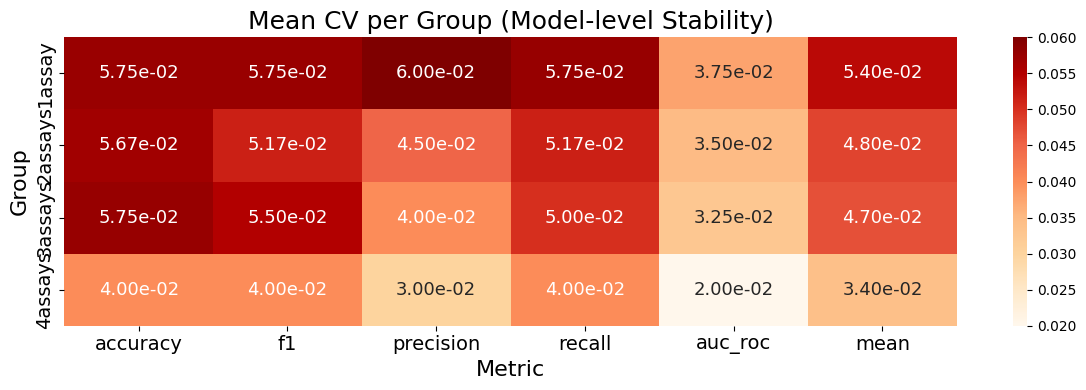

C:\Users\laura\AppData\Local\Temp\ipykernel_55912\3273746283.py:120: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  within_group_cv_df.replace('-', np.nan),


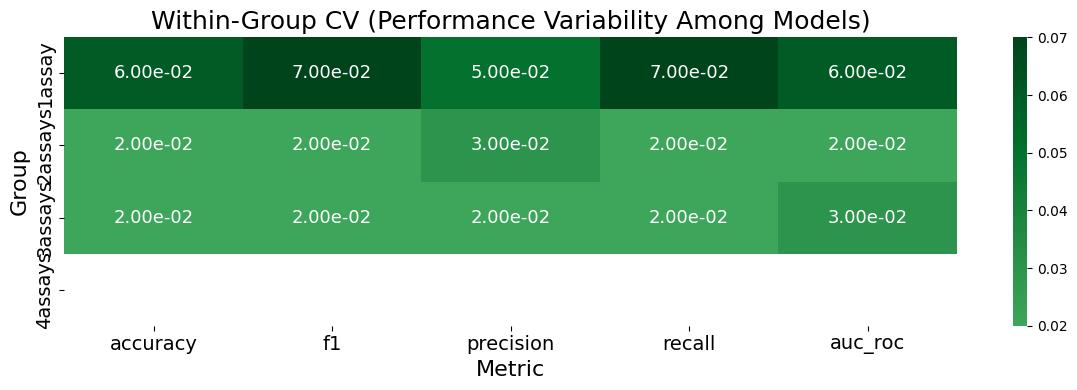

✅ 所有图已保存并显示！


In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 加载 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 2. 原始指标名 & 映射到标准名 ===
original_metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']
rename_map = {
    'balanced_acc': 'accuracy',
    'f1_score': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_auroc': 'auc_roc'
}
metrics = [rename_map[m] for m in original_metrics]

# === 3. 计算均值和CV ===
mean_data = {}
cv_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    cv_data[name] = {}
    for ori_metric in original_metrics:
        if ori_metric in df.columns:
            values = df[ori_metric]
            mean_val = values.mean()
            std_val = values.std()
            cv_val = std_val / mean_val if mean_val != 0 else np.nan
            std_name = rename_map[ori_metric]
            mean_data[name][std_name] = round(mean_val, 2)
            cv_data[name][std_name] = round(cv_val, 2)
        else:
            std_name = rename_map[ori_metric]
            mean_data[name][std_name] = np.nan
            cv_data[name][std_name] = np.nan

# === 4. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
cv_df = pd.DataFrame(cv_data).T

# === 5. 分组 ===
assay_groups = {}
for model_name in mean_df.index:
    assay_count = model_name.count('_') + 1
    group_key = f"{assay_count}assay" if assay_count == 1 else f"{assay_count}assays"
    assay_groups.setdefault(group_key, []).append(model_name)

# === 6. 计算 group mean 和 group CV ===
group_mean_df = pd.DataFrame(columns=metrics)
group_avg_cv_df = pd.DataFrame(columns=metrics)

for group_name, model_list in assay_groups.items():
    selected_mean = mean_df.loc[model_list]
    group_mean_df.loc[group_name] = selected_mean.mean()
    selected_cv = cv_df.loc[model_list]
    group_avg_cv_df.loc[group_name] = selected_cv.mean()

# === 7. 添加 mean 列 ===
group_mean_df['mean'] = group_mean_df.mean(axis=1)
group_avg_cv_df['mean'] = group_avg_cv_df.mean(axis=1)

# === 8. 组内差异 CV（模型之间） ===
within_group_cv_df = pd.DataFrame(columns=metrics)
for group_name, model_list in assay_groups.items():
    if len(model_list) <= 1:
        within_group_cv_df.loc[group_name] = ['-' for _ in metrics]
        continue
    selected_means = mean_df.loc[model_list]
    group_cv = selected_means.std() / selected_means.mean()
    within_group_cv_df.loc[group_name] = group_cv.round(2)

# === 9. 可视化并保存并显示 ===
fig_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"

# 图1：Mean Performance
plt.figure(figsize=(12, 4))
sns.heatmap(group_mean_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Mean Performance by Assay Count')
plt.xlabel("Metric")
plt.ylabel("Group")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_mean_performance_flexynesis.png"), dpi=300)
plt.show()  # 显示图像

# 图2：CV per group（模型稳定性）
plt.figure(figsize=(12, 4))
sns.heatmap(group_avg_cv_df, annot=True, cmap='OrRd', fmt=".2f")
plt.title('Mean of CV per Group (Model-level Stability)')
plt.xlabel("Metric")
plt.ylabel("Group")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_model_stability_cv_flexynesis.png"), dpi=300)
plt.show()  # 显示图像

# 图3：组内差异 CV（模型间差异）
plt.figure(figsize=(12, 4))
sns.heatmap(
    within_group_cv_df.replace('-', np.nan),
    annot=within_group_cv_df,
    cmap='coolwarm',
    fmt='',
)
plt.title('Within-Group CV (Performance Variability Among Models)')
plt.xlabel("Metric")
plt.ylabel("Group")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, "group_within_variability_cv_flexynesis.png"), dpi=300)
plt.show()  # 显示图像

print("✅ 所有图已保存并显示！")


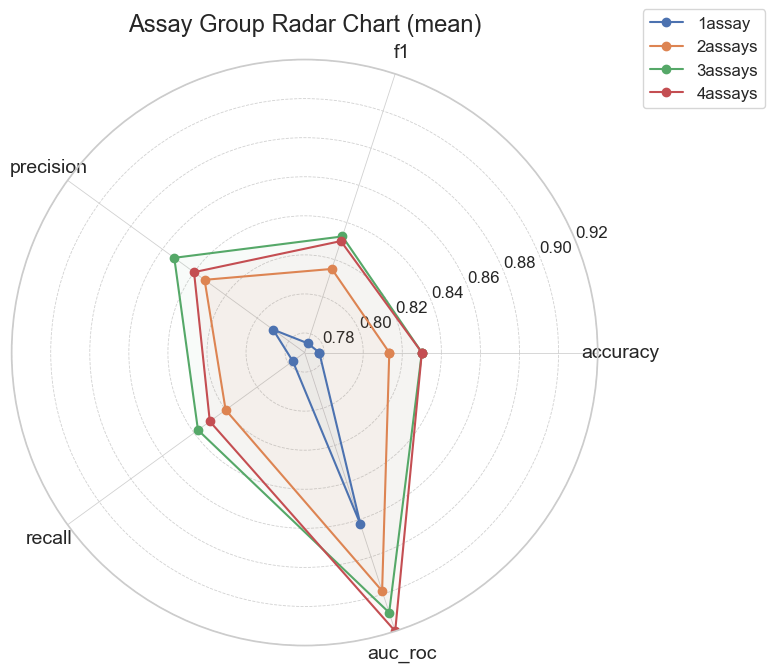

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 保存路径
fig_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\Thesis write up\figures"

# 替换列名为标准形式（如已改过可跳过）
rename_map = {
    'balanced_acc': 'accuracy',
    'f1_score': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'average_auroc': 'auc_roc'
}
group_mean_df = group_mean_df.rename(columns=rename_map)

# 筛除不需要的列
metrics = [col for col in group_mean_df.columns if col not in ['mean', 'average_aupr']]

# 设置角度 & 闭合路径
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# 开始绘图
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# ✅ 淡化雷达圆圈（极坐标网格线）
ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.9)  # 添加这行
ax.xaxis.grid(True, linestyle='-', linewidth=0.6, alpha=0.9)

# 每个 group 的雷达线和填充
for group_name in group_mean_df.index:
    values = group_mean_df.loc[group_name, metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, marker='o', label=group_name)
    ax.fill(angles, values, alpha=0.04)

# 坐标轴设定
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=14)
ax.set_ylim(0.77, 0.92)
ax.set_title("Assay Group Radar Chart (mean)", pad=20, fontsize=17)

# 图例与布局
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()

# ✅ 保存图像
save_path = os.path.join(fig_folder, "assay_group_radar_mean_flexynesis.png")
plt.savefig(save_path, dpi=300)

# ✅ 显示图像
plt.show()
